# OSG Statistics by Elevation
i.e. How does the p95 wind change with elevation throughout a day

In [8]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import multiprocessing
import numpy as np
from collections import OrderedDict

import sys
import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_downloads.HRRR_S3 import *
from BB_wx_calcs.wind import wind_uv_to_spd
from BB_basemap.draw_maps import draw_CONUS_HRRR_map
from BB_data.grid_manager import pluck_point_new
from BB_MesoWest.MesoWest_STNinfo import get_MW_location_dict
from BB_MesoWest.MesoWest_timeseries import get_mesowest_ts
from BB_data.grid_manager import pluck_point_new

from matplotlib.dates import DateFormatter
formatter = DateFormatter('%b\n%d')

import matplotlib as mpl 
mpl.rcParams['figure.figsize'] = [10, 8]
mpl.rcParams['figure.titlesize'] = 15
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.05
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 300

In [3]:


# Load HRRR Lat/Lon/Elevation data
H = get_hrrr_variable(datetime(2017, 1, 1), variable='HGT:surface')
lat = H['lat']
lon = H['lon']

./temp_2017010100_f00_HGT.grib2
Oh, good, you requested a date that should be on Pando.
matched a variable 46:30408372:d=2017010100:HGT:surface:anl

range: 30408372 32644720


## Domain Center

In [54]:
# Brianhead
lat = 37.718
lon = -112.837

cut_v, cut_h = pluck_point_new(lat,
                               lon,
                               H['lat'],
                               H['lon'])

size = 30

# Create Map object for test plotting
m = Basemap(resolution='i', projection='cyl',\
            llcrnrlon=H['lon'][cut_v-size,cut_h-size][0], llcrnrlat=H['lat'][cut_v-size,cut_h-size][0],\
            urcrnrlon=H['lon'][cut_v+size,cut_h+size][0], urcrnrlat=H['lat'][cut_v+size,cut_h+size][0],)

In [55]:
# D is for the domain limits
D = np.meshgrid(range(cut_v[0]-size,cut_v[0]+size), range(cut_h[0]-size,cut_h[0]+size))


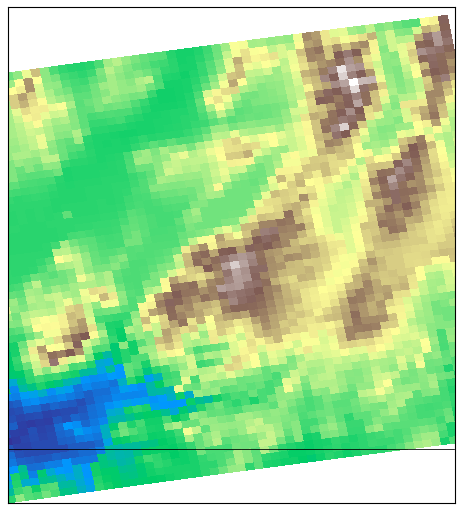

In [56]:
m.pcolormesh(H['lon'][D], H['lat'][D], H['value'][D],
             cmap='terrain')
m.drawstates()

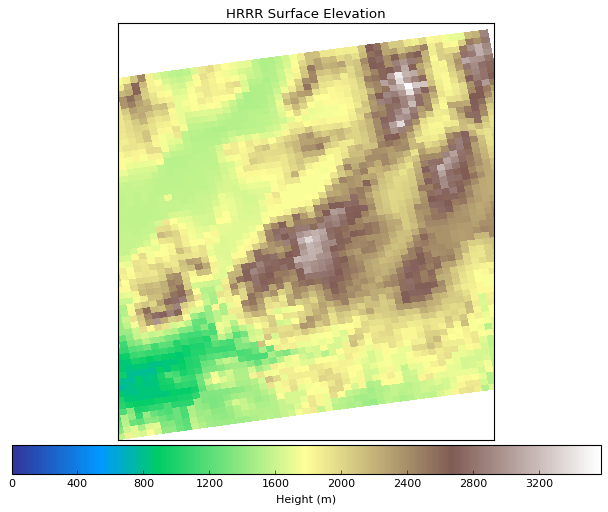

In [57]:
m.drawcoastlines()
m.pcolormesh(H['lon'][D], H['lat'][D], H['value'][D],
             cmap='terrain',
             vmin=0,
             latlon=True)
cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=.95)
cb.set_label('Height (m)')
plt.title('HRRR Surface Elevation')

Create height bins for the data

In [58]:
HGT_bins = np.arange(0, H['value'].max(), 100)
HGT_bins = np.append(HGT_bins, H['value'].max())
HGT_bins = np.append(H['value'].min(), HGT_bins)
HGT_bins[1] = 0.100

print HGT_bins

[ -7.49422455e+01   1.00000000e-01   1.00000000e+02   2.00000000e+02
   3.00000000e+02   4.00000000e+02   5.00000000e+02   6.00000000e+02
   7.00000000e+02   8.00000000e+02   9.00000000e+02   1.00000000e+03
   1.10000000e+03   1.20000000e+03   1.30000000e+03   1.40000000e+03
   1.50000000e+03   1.60000000e+03   1.70000000e+03   1.80000000e+03
   1.90000000e+03   2.00000000e+03   2.10000000e+03   2.20000000e+03
   2.30000000e+03   2.40000000e+03   2.50000000e+03   2.60000000e+03
   2.70000000e+03   2.80000000e+03   2.90000000e+03   3.00000000e+03
   3.10000000e+03   3.20000000e+03   3.30000000e+03   3.40000000e+03
   3.50000000e+03   3.60000000e+03   3.70000000e+03   3.80000000e+03
   3.90000000e+03   4.00000000e+03   4.10000000e+03   4.18377637e+03]


In [59]:
# Plot the bins by contourf
m.contourf(lon, lat, H['value'],
           latlon=True,
           levels=HGT_bins,
           cmap='flag')
cb = plt.colorbar(orientation='horizontal', pad=0.01, shrink=.95)
cb.set_label('Height (m)')
plt.title('HRRR Surface Elevation Bins')
m.drawcoastlines()

ValueError: 1-d or 2-d longitudes required

In [5]:
storage_p95 = np.zeros([len(HGT_bins), 24])
storage_samples = np.zeros([len(HGT_bins), 24])
print np.shape(storage_p95)

(44, 24)


Load the percentile data

In [62]:
month = 8
day = 15

STAT = 'p95'

var = 'REFC:entire'
variable = var.replace(':', '_').replace(' ', '_')
varSAVE = var.replace(':', '').replace(' ', '')


if var == 'UVGRD:10 m':
    cmap = 'Blues'
    cblabel = r'10 m Wind Speed (m s$\mathregular{^{-1}}$)'
    vmax = 23
    vmin = 0
elif var == 'UVGRD:80 m':
    cmap = 'BuPu'
    cblabel = r'80 m Wind Speed (m s$\mathregular{^{-1}}$)'
    vmax = 25
    vmin = 0
elif var == 'TMP:2 m':
    cmap = 'Spectral_r'
    cblabel = '2 m Temperture (C)'
    vmax = 50
    vmin = -10
elif var == 'DPT:2 m':
    cmap = 'BrBG'
    cblabel = '2 m Dew Point (C)'
elif var == 'DPT:2 m':
    cmap = 'BrBG'
    cblabel = '2 m Dew Point (C)'
    vmax = 30
    vmin = -10
elif var == 'REFC:entire':
    cmap = 'gist_ncar'
    cblabel = 'Composite Reflectivity (dBZ)'
    vmax = 40
    vmin = -10
    
# open the file for each hour
for hour in range(0, 24):
    DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)
    FILE = DIR + 'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % \
                  (variable, month, day, hour)

    with h5py.File(FILE, 'r') as f:
        if var == 'TMP:2 m' or var == 'DPT:2 m':
            p95 = f[STAT][D].value - 273.15
        else:
            p95 = f[STAT][D].value
    
    # Loop through each elevation section
    for i in range(len(HGT_bins)-1):
        pixels_in_bin = np.logical_and(H['value'] > HGT_bins[i], H['value'] <= HGT_bins[i+1])

        p95_bin = p95
        p95_bin = np.ma.array(p95_bin)
        p95_bin[pixels_in_bin == False] = np.ma.masked

        area_per = np.percentile(p95[pixels_in_bin], [95])
        
        storage_p95[i, hour] = area_per[0]
        storage_samples[i, hour] = np.sum(pixels_in_bin)

        if hour == -1:
            plt.figure(i)
            m.drawcoastlines()
            m.pcolormesh(lon, lat, p95_bin,
                         cmap='viridis',
                         vmax=20, vmin=0,
                         latlon=True)
            plt.title('Elevation Bin:%.2f-%.2f\nSamples:%s p50=%s, p95=%s Mean:%s' % (HGT_bins[i], HGT_bins[i+1], np.sum(pixels_in_bin), area_per[0], area_per[1], np.mean(p95_bin)))
            plt.savefig('./figs/elev_bin_%02d' % (i))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [61]:
print np.shape(storage_p95)
plt.title('Area p95 of the 3-year p95\nMonth: %s; Day: %02d' % (month, day))
plt.pcolormesh(range(0,25), HGT_bins, storage_p95,
               cmap=cmap,
               vmax=vmax,
               vmin=vmin)
cb = plt.colorbar(orientation='vertical', pad=0.01, shrink=.95)
cb.set_label(cblabel)

plt.ylim([HGT_bins[0], HGT_bins[-1]])
plt.ylabel('Surface Height (m)')
plt.xlabel('Hour of Day (UTC)')
plt.xlim([0, 24])
t = plt.xticks(np.arange(0.5,24,1), ['%02d' % h for h in range(0,24)])

plt.savefig('./figs/HRRR_%s_p95ofp95_m%02d_d%02d_HOURS' % (varSAVE, month, day))

NameError: name 'storage_p95' is not defined

#### Plot number of samples in each bin

[  6.60600000e+05   1.51512000e+05   1.40490000e+05   1.52659000e+05
   1.46312000e+05   9.12240000e+04   5.66760000e+04   4.47920000e+04
   4.22890000e+04   3.44440000e+04   3.01330000e+04   2.70590000e+04
   2.70200000e+04   3.33630000e+04   3.24240000e+04   3.12780000e+04
   2.84190000e+04   2.39050000e+04   2.31080000e+04   2.15890000e+04
   1.90120000e+04   1.87160000e+04   1.57760000e+04   1.17110000e+04
   9.61600000e+03   7.35600000e+03   5.50800000e+03   4.16500000e+03
   3.28400000e+03   2.50500000e+03   1.96600000e+03   1.53900000e+03
   1.22800000e+03   9.79000000e+02   7.44000000e+02   6.00000000e+02
   4.48000000e+02   3.22000000e+02   1.98000000e+02   1.01000000e+02
   5.10000000e+01   1.50000000e+01   3.00000000e+00   0.00000000e+00]


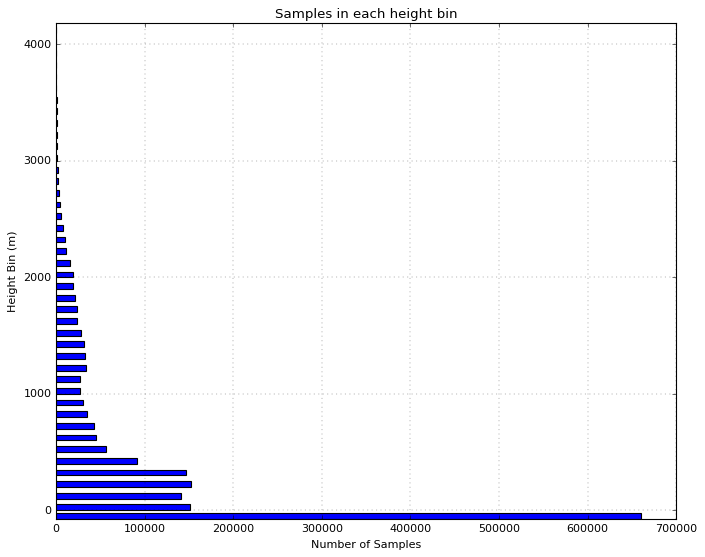

In [132]:
plt.title('Samples in each height bin')
t = plt.barh(HGT_bins, storage_samples[:,0], height=50 )
plt.ylim([HGT_bins[0], HGT_bins[-1]])
plt.xlabel('Number of Samples')
plt.ylabel('Height Bin (m)')
plt.grid()
plt.savefig('./figs/HRRR_samples')

#for i, v in enumerate(storage_samples[:,0]):
#    plt.text(v + 3, HGT_bins[i], str(v), color='blue', fontweight='bold')

print storage_samples[:,0]